# Food101 Classification Using ResNet50 (88% training acc, 85% validation)

# 1. Import libraries

In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import os
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import time
import h5py

In [2]:
# To ignore warinings
import warnings
warnings.filterwarnings('ignore')

os.environ["WANDB_DISABLED"] = "true"
# Disabling W&B during development or testing phases 
# to avoid unnecessary overhead or interactions with external services.

# 2. Setting up GPU

In [3]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(0))

Using device: cuda
Tesla P100-PCIE-16GB


# 3. Custom Food-101 class

In [4]:
# Define the custom dataset class
class Food101Dataset(Dataset):
    def __init__(self, json_path, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
    
        # Load and process the JSON file
        with open(json_path) as f:
            data = json.load(f)
        
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(data.keys())}
        
        for cls_name, images in data.items():
            cls_idx = self.class_to_idx[cls_name]
            for img_path in images:
                self.image_paths.append(img_path)
                self.labels.append(cls_idx)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, 'images', f"{self.image_paths[idx]}.jpg")
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 4. Set Paths to input the data

In [5]:
# Set paths for Food-101 dataset
root_dir = "/kaggle/input/food41"  
train_json = os.path.join(root_dir, "meta", "meta", "train.json")
test_json = os.path.join(root_dir, "meta", "meta", "test.json")

# 5. Defining transformations, dataloaders
## A. I tried to apply different data augmentation techniques to enhance the generalization of the model
## B. Used batch size of 256

In [6]:
# Defining data transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  
    transforms.RandomAffine(0, translate=(0.08, 0.08), scale=(0.95, 1.05)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  
    transforms.RandomGrayscale(p=0.05),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])


train_dataset = Food101Dataset(
    json_path=train_json,
    root_dir=root_dir,
    transform=train_transform
)

val_dataset = Food101Dataset(
    json_path=test_json,
    root_dir=root_dir,
    transform=val_transform
)


# Create data loaders
batch_size = 256
  

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=True
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.class_to_idx)}")

Number of training samples: 75750
Number of validation samples: 25250
Number of classes: 101


In [7]:
# Test the dataloader
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

print("\n\n")
for images, labels in val_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])



Batch shape: torch.Size([256, 3, 224, 224])
Labels shape: torch.Size([256])


# 6. Visualizing some data

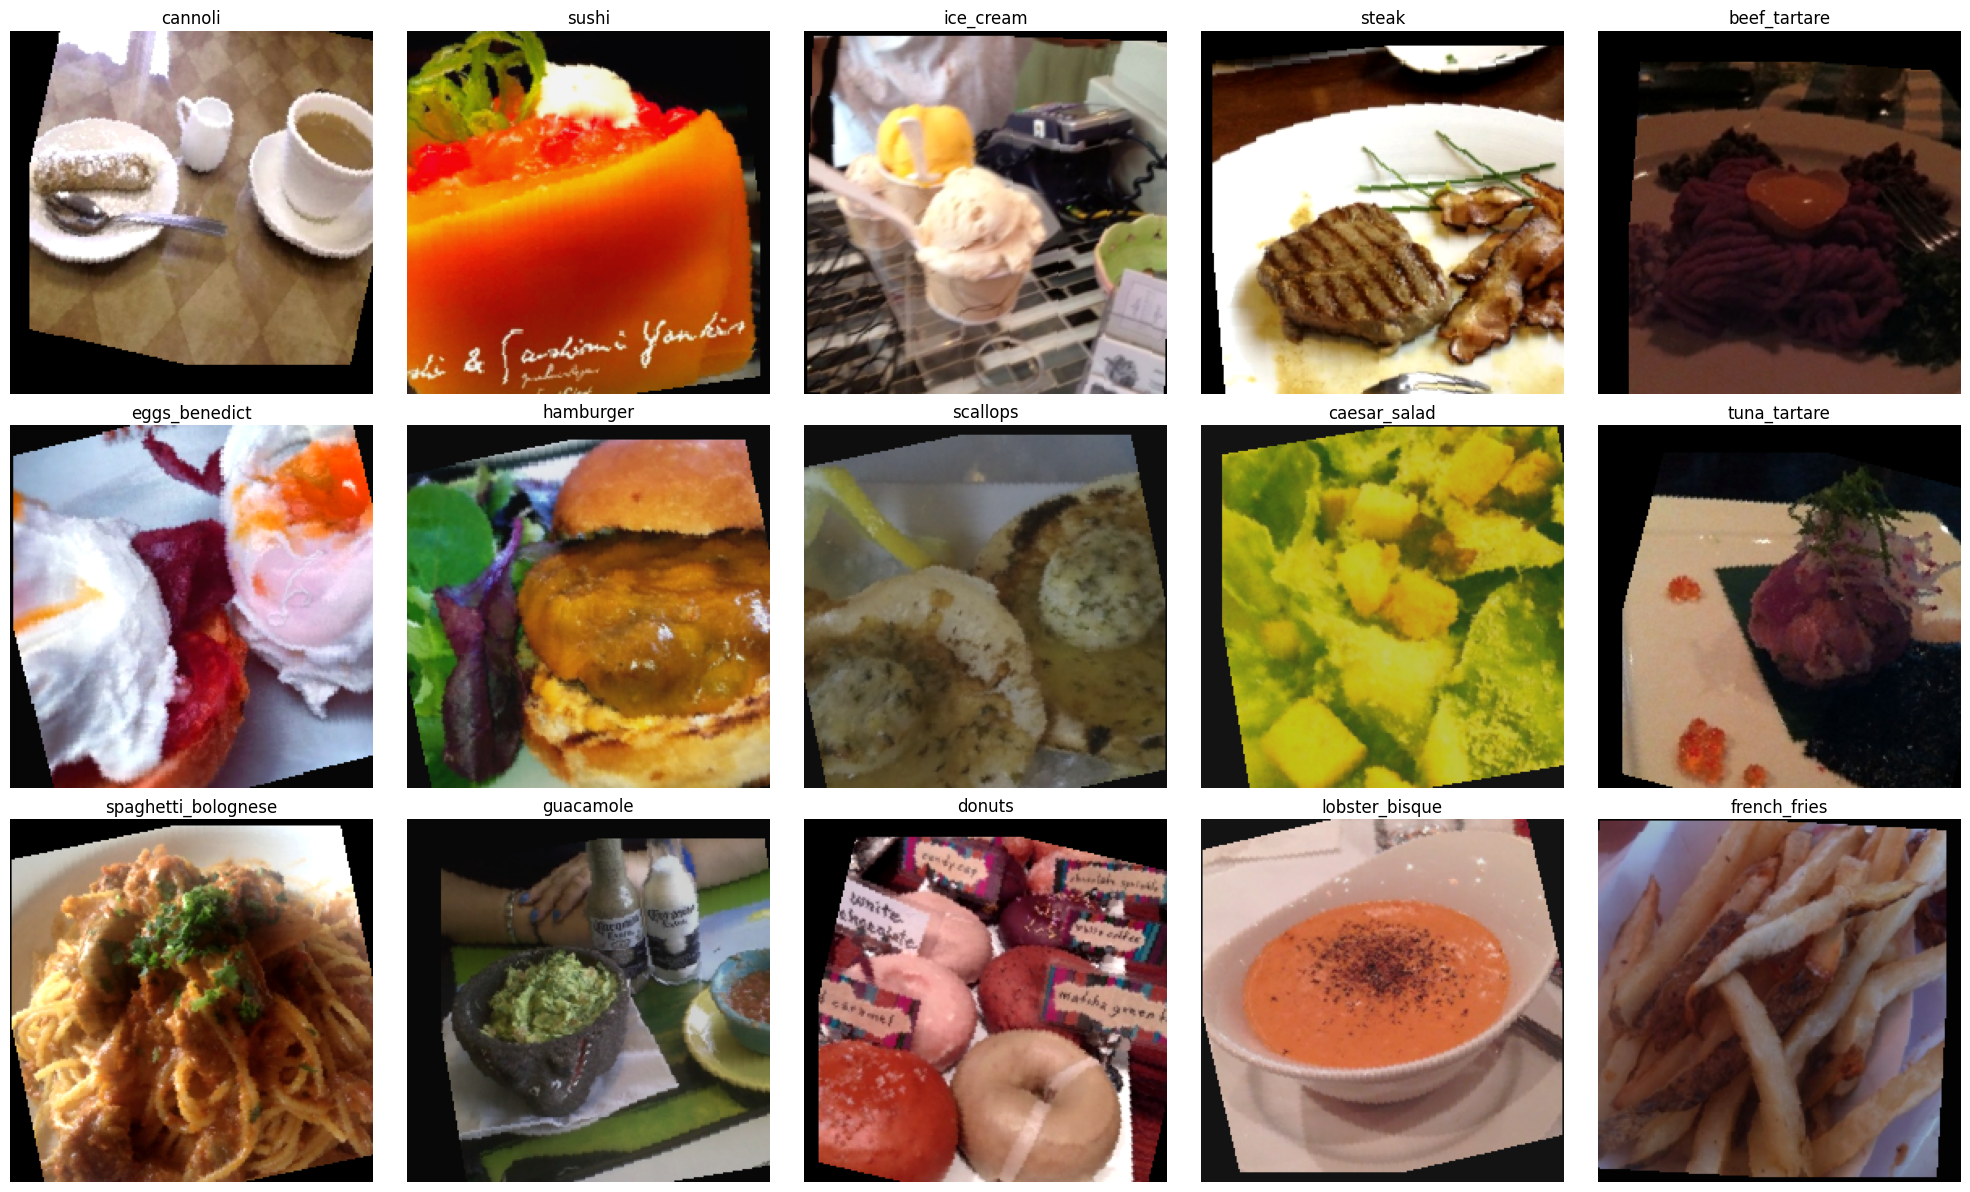

In [12]:
# Create a figure with subplots
num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))

# Get inverse mapping of class indices to names
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Get random indices
indices = random.sample(range(len(train_dataset)), num_rows * num_cols)

for idx, ax in enumerate(axes.flat):
    # Get image and label
    img, label = train_dataset[indices[idx]]
    
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    
    # Convert to PIL Image and then numpy array
    img = transforms.ToPILImage()(img.clamp(0, 1))
    img = np.array(img)
    
    # Plot
    ax.imshow(img)
    ax.set_title(idx_to_class[label], pad=5)
    ax.axis('off')

plt.tight_layout()
plt.show()

# 7. Import ResNet50 as a pretrained base model for training

In [8]:
weights = torchvision.models.ResNet50_Weights.DEFAULT
resnet = torchvision.models.resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.7MB/s]


In [9]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
summary(resnet.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 8. Model Configuration

## Architecture Modifications
- ### Modified ResNet's final layer with:
  ### - Dropout (p=0.3)
  ### - Linear layer (output: 101 classes)

## Training Strategy
- ### **Transfer Learning Approach**:
  ### Froze all base layers
  ### Unfroze only layer4 and fc layers for fine-tuning

## Training Parameters
### - 20 epochs
### - Learning Rate: 0.001
### - L2 Regularization: 1e-3
### - Loss Function: CrossEntropyLoss
### - Optimizer: Adam
- ### LR Scheduler: StepLR
  #### - Step Size: 5 epochs
  #### - Gamma: 0.2 (reduces LR by a factor of 0.2 every 5 epochs)

In [11]:
# Modify the final layer with dropout
resnet.fc = nn.Sequential(
    nn.Dropout(0.3),  
    nn.Linear(resnet.fc.in_features, 101)
)

# Freeze all layers
for param in resnet.parameters():
    param.requires_grad = False

# Unfreeze specific layers
for name, param in resnet.named_parameters():
    if any(x in name for x in ['layer4', 'fc']): 
        param.requires_grad = True

In [12]:
resnet.to(device);

In [13]:
lr = 0.001
l2 = 1e-3
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr, weight_decay=l2)

In [14]:
# StepLR - reduces learning rate by a factor at specified intervals
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,        # Reduce LR every 5 epochs
    gamma=0.2          # Reduce LR by factor of 0.2
)

In [15]:
def train_model():
    numepochs = 20
     
    # Initialize losses / accuracies
    trainLoss = torch.zeros(numepochs)
    valLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    valAcc = torch.zeros(numepochs)
    
    start_time = time.time()
    for epochi in range(numepochs):
        epoch_start_time = time.time()
        
        # Train mode
        resnet.train()
        
        # Training
        batch_train_loss = []
        batch_train_acc = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            yHat = resnet(X)
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_train_loss.append(loss.item())
            batch_train_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
        
        trainLoss[epochi] = np.mean(batch_train_loss)
        trainAcc[epochi] = 100 * np.mean(batch_train_acc)
        
        # Eval mode
        resnet.eval()
        
        with torch.no_grad():
            batch_val_loss = []
            batch_val_acc = []
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                
                yHat = resnet(X)
                loss = lossfun(yHat, y)
                
                batch_val_loss.append(loss.item())
                batch_val_acc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            
            valLoss[epochi] = np.mean(batch_val_loss)
            valAcc[epochi] = 100 * np.mean(batch_val_acc)
        
        # Step the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        epoch_time = (time.time() - epoch_start_time) / 60
        total_time = (time.time() - start_time) / 60  # Convert to minutes
        
        # Print progress
        sys.stdout.write(f"\rFinished epoch: {epochi+1}/{numepochs}, "
                        f"time: {epoch_time:.2f}m, "
                        f"total time: {total_time:.2f}m, "
                        f"lr: {current_lr:.5f}")
    
    print("\nTraining completed!")
    
    # Save final model to Kaggle output directory
    output_dir = '/kaggle/working/'
    model_path = os.path.join(output_dir, 'food101_model.pth')
    
    final_model_state = {
        'model_state_dict': resnet.state_dict(),
        'class_to_idx': train_dataset.class_to_idx,
        'idx_to_class': {v: k for k, v in train_dataset.class_to_idx.items()}
    }
    torch.save(final_model_state, model_path)
    print(f"\nModel saved to: {model_path}")
    
    return trainLoss, valLoss, trainAcc, valAcc

# 9. Training the model (took around ~8 hours of training on GPU P100)

In [16]:
trainLoss, valLoss, trainAcc, valAcc = train_model()

Finished epoch: 20/20, time: 20.73m, total time: 473.00m, lr: 0.00000
Training completed!

Model saved to: /kaggle/working/food101_model.pth


# 10. Results (Accuracy vs loss) on training and validation

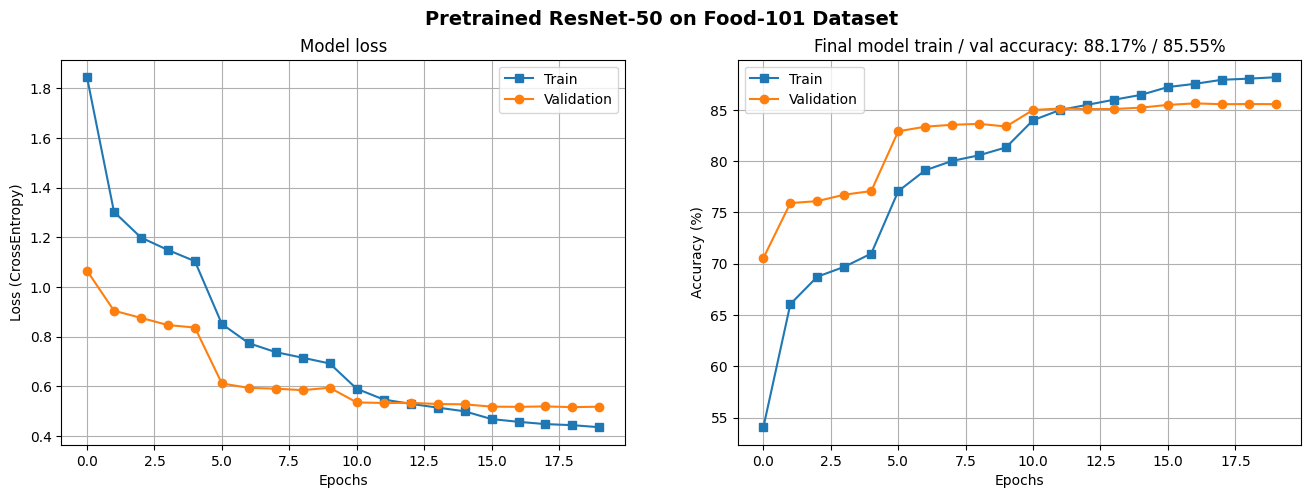

In [17]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss, 's-', label='Train')
ax[0].plot(valLoss, 'o-', label='Validation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CrossEntropy)')
ax[0].set_title('Model loss')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(trainAcc, 's-', label='Train')
ax[1].plot(valAcc, 'o-', label='Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train / val accuracy: {trainAcc[-1]:.2f}% / {valAcc[-1]:.2f}%')
ax[1].legend()
ax[1].grid(True)

fig.suptitle('Pretrained ResNet-50 on Food-101 Dataset', fontweight='bold', fontsize=14)
plt.show()

# 11. Testing the model using the H5 test data files
## Here, I used only the 128x128x3 RGB file since it was the closest to the input model (224x224x3) and giving reasonable results

In [19]:
def load_model():
    # Initialize the model architecture
    model = torchvision.models.resnet50()
    model.fc = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(model.fc.in_features, 101)
    )
    
    # Load the saved state
    checkpoint = torch.load('/kaggle/working/food101_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    idx_to_class = checkpoint['idx_to_class']
    
    model = model.to(device)
    model.eval()
    return model, idx_to_class

In [34]:
def test_model():
    model, idx_to_class = load_model()
    
    test_file = '/kaggle/input/food41/food_test_c101_n1000_r128x128x3.h5'
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Get class mapping
    with h5py.File(test_file, 'r') as f:
        h5_category_names = [name.decode('utf-8') for name in f['category_names'][:]]
        
    # Create mapping between H5 indices and model indices
    h5_to_model_idx = {}
    for h5_idx, h5_name in enumerate(h5_category_names):
        clean_name = h5_name.lower().replace(' ', '_')
        for model_idx, model_name in idx_to_class.items():
            if clean_name == model_name:
                h5_to_model_idx[h5_idx] = model_idx
                break
    
    print(f"\nTesting on {test_file.split('/')[-1]}")
    
    with h5py.File(test_file, 'r') as f:
        images = f['images'][:]
        labels = f['category'][:]
        
        h5_labels = np.argmax(labels, axis=1)
        model_labels = np.array([h5_to_model_idx[label] for label in h5_labels])
        
        correct = 0
        total = 0
        
        batch_size = 32
        num_samples = len(images)
        
        for i in range(0, num_samples, batch_size):
            batch_images = images[i:i+batch_size]
            batch_labels = model_labels[i:i+batch_size]
            
            batch_tensors = []
            for img in batch_images:
                img = Image.fromarray(img.astype('uint8'))
                img_tensor = transform(img)
                batch_tensors.append(img_tensor)
            
            batch_tensors = torch.stack(batch_tensors).to(device)
            batch_labels = torch.from_numpy(batch_labels).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensors)
                _, predicted = torch.max(outputs.data, 1)
                
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

# 12. Testing the model

In [35]:
test_model()


Testing on food_test_c101_n1000_r128x128x3.h5
Test Accuracy: 68.30%


# 13. Classification Report

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model():
    model, idx_to_class = load_model()
    
    # Test file path
    test_file = '/kaggle/input/food41/food_test_c101_n1000_r128x128x3.h5'
    
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Get class mapping
    with h5py.File(test_file, 'r') as f:
        h5_category_names = [name.decode('utf-8') for name in f['category_names'][:]]
        
    # Create mapping between H5 indices and model indices
    h5_to_model_idx = {}
    for h5_idx, h5_name in enumerate(h5_category_names):
        clean_name = h5_name.lower().replace(' ', '_')
        for model_idx, model_name in idx_to_class.items():
            if clean_name == model_name:
                h5_to_model_idx[h5_idx] = model_idx
                break
    
    print(f"\nEvaluating on {test_file.split('/')[-1]}")
    
    all_predictions = []
    all_labels = []
    
    with h5py.File(test_file, 'r') as f:
        images = f['images'][:]
        labels = f['category'][:]
        
        h5_labels = np.argmax(labels, axis=1)
        model_labels = np.array([h5_to_model_idx[label] for label in h5_labels])
        
        batch_size = 32
        num_samples = len(images)
        
        for i in range(0, num_samples, batch_size):
            batch_images = images[i:i+batch_size]
            batch_labels = model_labels[i:i+batch_size]
            
            batch_tensors = []
            for img in batch_images:
                img = Image.fromarray(img.astype('uint8'))
                img_tensor = transform(img)
                batch_tensors.append(img_tensor)
            
            batch_tensors = torch.stack(batch_tensors).to(device)
            
            with torch.no_grad():
                outputs = model(batch_tensors)
                _, predicted = torch.max(outputs.data, 1)
                
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels)
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Get class names for report
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
    
    # Generate classification report
    report = classification_report(
        all_labels, 
        all_predictions, 
        target_names=class_names,
        digits=3
    )
    print("\nClassification Report:")
    print(report)
    
    # Calculate per-class accuracy
    cm = confusion_matrix(all_labels, all_predictions)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    # Get best and worst performing classes
    class_accuracies = list(zip(class_names, per_class_accuracy))
    class_accuracies.sort(key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 Best Performing Classes:")
    for class_name, accuracy in class_accuracies[:10]:
        print(f"{class_name}: {accuracy:.3f}")
    
    print("\nTop 10 Worst Performing Classes:")
    for class_name, accuracy in class_accuracies[-10:]:
        print(f"{class_name}: {accuracy:.3f}")

# Run the evaluation
evaluate_model()


Evaluating on food_test_c101_n1000_r128x128x3.h5

Classification Report:
                         precision    recall  f1-score   support

                churros      0.600     0.900     0.720        10
      hot_and_sour_soup      0.750     0.750     0.750        12
                 samosa      1.000     0.400     0.571        10
                sashimi      1.000     1.000     1.000         8
              pork_chop      0.529     0.562     0.545        16
           spring_rolls      0.667     0.800     0.727         5
            panna_cotta      0.700     0.467     0.560        15
           beef_tartare      0.444     0.400     0.421        10
            greek_salad      0.875     0.875     0.875         8
              foie_gras      0.750     0.692     0.720        13
                  tacos      0.500     0.333     0.400         6
               pad_thai      0.875     0.700     0.778        10
                poutine      0.700     0.636     0.667        11
               

# 14. Model Performance Analysis

## 🌟 Top Performing Classes (100% Accuracy)
| Food Class | Accuracy |
|------------|----------|
| Sashimi | 100% |
| Beignets | 100% |
| Crème Brûlée | 100% |
| Edamame | 100% |
| Macaroni & Cheese | 100% |
| Red Velvet Cake | 100% |
| French Fries | 100% |
| Takoyaki | 100% |
| Hot Dog | 100% |
| Pho | 100% |

## 📉 Classes Needing Improvement
| Food Class | Accuracy |
|------------|----------|
| French Toast | 16.7% |
| Breakfast Burrito | 25.0% |
| Falafel | 25.0% |
| Apple Pie | 25.0% |
| Risotto | 28.6% |
| Tuna Tartare | 30.0% |
| Chocolate Mousse | 33.3% |
| Tacos | 33.3% |
| Crab Cakes | 36.4% |
| Fried Rice | 40.0% |

## 🔍 Observations
- Perfect classification for distinct, visually unique dishes
- Lower performance on dishes with variable appearances or similar-looking alternatives
- Challenging cases often involve mixed ingredients or varied preparation styles